In [ ]:

!pip install efficientnet_pytorch

import torch
import torchvision
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.optim import lr_scheduler
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import cv2
from glob import glob
import shutil  # Ensure this is included to handle file copying

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load and resize images
def load_image(img_path, resize=True):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    if resize:
        img = cv2.resize(img, (212, 212), interpolation=cv2.INTER_AREA)

    return img

# Show a single image
def show_image(img_path):
    img = load_image(img_path)
    plt.imshow(img)
    plt.axis('off')

# Show a grid of images
def show_sign_grid(image_paths):
    images = []

    for img in image_paths:
        try:
            loaded_img = load_image(img)
            if loaded_img is not None:
                images.append(loaded_img)
        except Exception as e:
            print(f"Error loading image {img}: {e}")

    if len(images) == 0:
        print("No images to display.")
        return

    images = torch.as_tensor(images)

    if len(images.shape) == 4:  # Check if the dimensions are correct
        images = images.permute(0, 3, 1, 2)  # Convert to (batch_size, channels, height, width)
        grid_img = torchvision.utils.make_grid(images, nrow=11)
        plt.figure(figsize=(24, 12))
        plt.imshow(grid_img.permute(1, 2, 0))  # Convert back for displaying
        plt.axis('off')
    else:
        print("Unexpected image dimensions:", images.shape)


<ipython-input-4-9b4d0708a28b>:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  images = torch.as_tensor(images)


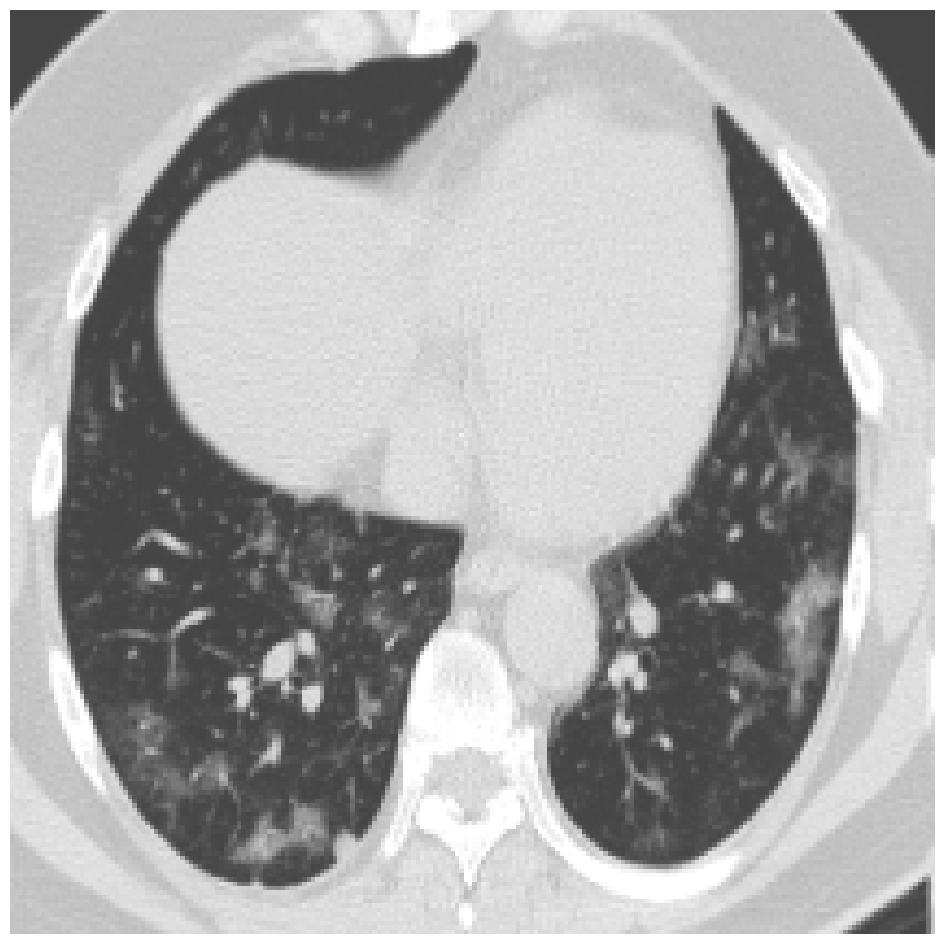

In [ ]:
# Set the paths
train_path = '/content/drive/MyDrive/Dataset/train/*'
test_path = '/content/drive/MyDrive/Dataset/test/*'
dataset_path = '/content/drive/MyDrive/Dataset'

# Display sample images from training data
train_folders = sorted(glob(train_path))
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in train_folders]
show_sign_grid(sample_images)

# Display a specific image
img_path = glob(f'{train_folders[1]}/*png')[2]
show_image(img_path)


In [ ]:
# Class names and indices
class_names = ['NEGATIVE', 'POSITIVE']
class_indices = [0, 1]

# Set up data directories for training and validation
DATA_DIR = Path('data')
DATASETS = ['train', 'val']

for ds in DATASETS:
    for cls in class_names:
        (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

# Organize images into training and validation directories
for i, cls_index in enumerate(class_indices):
    image_paths = np.array(glob(f'{train_folders[cls_index]}/*.png'))
    class_name = class_names[i]
    print(f'{class_name}: {len(image_paths)}')
    np.random.shuffle(image_paths)

    ds_split = np.split(image_paths, indices_or_sections=[int(.8 * len(image_paths))])

    dataset_data = zip(DATASETS, ds_split)

    for ds, images in dataset_data:
        for img_path in images:
            shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')


NEGATIVE: 2000
POSITIVE: 2000


In [ ]:
# Data augmentation and normalization for training and validation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {
    'train': T.Compose([
        T.RandomResizedCrop(size=512),
        T.ToTensor(),
        T.Normalize(mean_nums, std_nums)
    ]),
    'val': T.Compose([
        T.Resize(size=350),
        T.CenterCrop(size=299),
        T.ToTensor(),
        T.Normalize(mean_nums, std_nums)
    ])
}


In [ ]:
# Load the datasets
image_datasets = {
    d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

# Creating DataLoader
data_loaders = {
    d: DataLoader(image_datasets[d], batch_size=16, shuffle=True, num_workers=2)
    for d in DATASETS
}

# Dataset sizes
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes


In [ ]:
# Create EfficientNet-B3 model
def create_efficientnet_model(n_classes):
    model = EfficientNet.from_pretrained('efficientnet-b3')
    in_features = model._fc.in_features
    model._fc = nn.Linear(in_features, n_classes)
    return model.to(device)

# Initialize model
base_model = create_efficientnet_model(len(class_names))


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 70.6MB/s]


Loaded pretrained weights for efficientnet-b3


In [ ]:
# Define optimizer, loss function, and scheduler
optimizer = optim.Adam(base_model.parameters(), lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_fn = nn.CrossEntropyLoss().to(device)


In [ ]:
# Training and evaluation loop
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    scheduler.step()
    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


In [ ]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=5):
    best_accuracy = 0
    history = defaultdict(list)

    for epoch in range(n_epochs):
        print(f'Epoch {epoch + 1}/{n_epochs}')
        print('-' * 10)

        train_acc, train_loss = train_epoch(
            model, data_loaders['train'], loss_fn, optimizer, device, scheduler, dataset_sizes['train']
        )

        print(f'Train loss: {train_loss} accuracy: {train_acc}')

        val_acc, val_loss = eval_model(
            model, data_loaders['val'], loss_fn, device, dataset_sizes['val']
        )

        print(f'Val loss: {val_loss} accuracy: {val_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        # Save the best model
        if val_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = val_acc

        print(f'Best validation accuracy: {best_accuracy}')

    # Load the best model after training
    model.load_state_dict(torch.load('best_model_state.bin'))
    return model, history


In [ ]:
# Start training
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device, n_epochs=15)


Epoch 1/15
----------
Train loss: 0.06128116875537671 accuracy: 0.974375
Val loss: 0.17447076119482519 accuracy: 0.935

Best validation accuracy: 0.935
Epoch 2/15
----------
Train loss: 0.05860969912144356 accuracy: 0.980625
Val loss: 0.1713909239321947 accuracy: 0.93625

Best validation accuracy: 0.93625
Epoch 3/15
----------
Train loss: 0.061000188200268896 accuracy: 0.9762500000000001
Val loss: 0.16548601195216178 accuracy: 0.9400000000000001

Best validation accuracy: 0.9400000000000001
Epoch 4/15
----------
Train loss: 0.06552710657531861 accuracy: 0.9771875
Val loss: 0.16976355470716953 accuracy: 0.93875

Best validation accuracy: 0.9400000000000001
Epoch 5/15
----------
Train loss: 0.061554260222474115 accuracy: 0.9778125
Val loss: 0.16578238308429719 accuracy: 0.9400000000000001

Best validation accuracy: 0.9400000000000001
Epoch 6/15
----------
Train loss: 0.062050231550238096 accuracy: 0.9765625
Val loss: 0.1681224236637354 accuracy: 0.93875

Best validation accuracy: 0.94000

<ipython-input-12-dad2fdacd788>:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_state.bin'))


In [ ]:
# Function to get predictions from the test set
def get_predictions(model, data_loader):
    model = model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds)
            real_values.extend(labels)

    predictions = torch.as_tensor(predictions).cpu()
    real_values = torch.as_tensor(real_values).cpu()
    return predictions, real_values


In [ ]:
# Assuming you have a test data loader ready:
y_pred, y_test = get_predictions(base_model, data_loaders['val'])

# Print classification report
print(classification_report(y_test, y_pred, target_names=class_names))


              precision    recall  f1-score   support

    NEGATIVE       0.98      0.73      0.84       400
    POSITIVE       0.78      0.98      0.87       400

    accuracy                           0.86       800
   macro avg       0.88      0.86      0.85       800
weighted avg       0.88      0.86      0.85       800



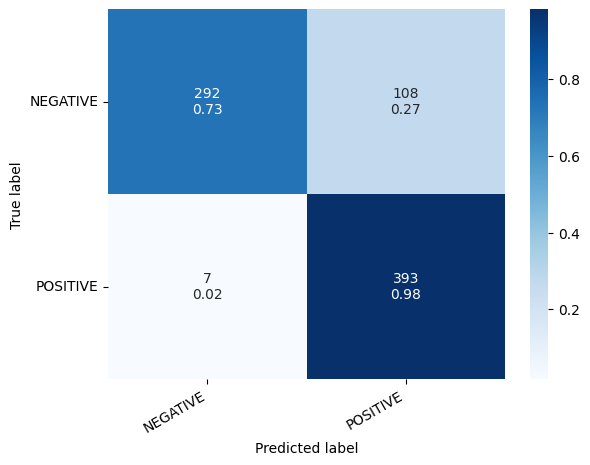

In [ ]:
# Function to show confusion matrix
def show_confusion_matrix(cm, class_names):
    cm = cm.copy()
    cell_counts = cm.flatten()
    cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]
    cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
    cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

    df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)
    hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Create confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

# Show confusion matrix
show_confusion_matrix(cm, class_names)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Gradients shape: (1, 384, 7, 9)
Activations shape: (1, 384, 7, 9)


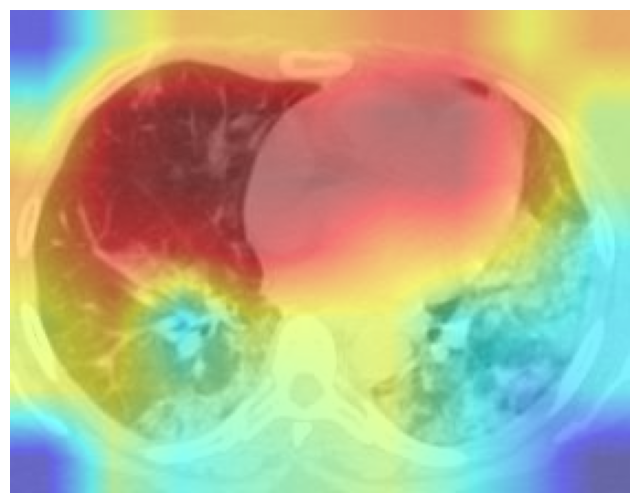

In [ ]:
from PIL import Image
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Helper to hook onto the final layer to get activations and gradients
class SaveFeatures:
    def __init__(self, layer):
        self.features = None
        self.gradients = None
        self.hook = layer.register_forward_hook(self.hook_fn)
        self.grad_hook = layer.register_backward_hook(self.hook_grad)

    def hook_fn(self, module, input, output):
        self.features = output.cpu().data.numpy()

    def hook_grad(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].cpu().data.numpy()

    def close(self):
        self.hook.remove()
        self.grad_hook.remove()

# Function to calculate the Grad-CAM heatmap
def get_gradcam_heatmap(model, image, target_class):
    model.eval()

    # Hook into the last convolutional layer of EfficientNet
    final_conv_layer = model._blocks[-1]._project_conv  # Hook into the projection conv layer
    activation = SaveFeatures(final_conv_layer)

    # Forward pass
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    output = model(image)

    # Get the score for the target class
    score = output[:, target_class].squeeze()

    # Backward pass to calculate gradients
    model.zero_grad()
    score.backward(retain_graph=True)

    # Get gradients from the final convolutional layer
    gradients = activation.gradients  # Use the saved gradients from the hook

    # Print the shape of the gradients for debugging
    print(f"Gradients shape: {gradients.shape}")  # Debugging

    # Get activations from the final convolutional layer
    activations = activation.features

    # Print the shape of activations for debugging
    print(f"Activations shape: {activations.shape}")  # Debugging

    # Calculate the weights by averaging gradients over the height and width axes
    weights = np.mean(gradients, axis=(2, 3))

    # Multiply the weights with activations to get the heatmap
    gradcam_map = np.zeros(activations.shape[2:], dtype=np.float32)
    for i, w in enumerate(weights[0]):
        gradcam_map += w * activations[0, i, :, :]

    # ReLU to remove negative values
    gradcam_map = np.maximum(gradcam_map, 0)

    # Normalize the heatmap
    gradcam_map = (gradcam_map - gradcam_map.min()) / (gradcam_map.max() - gradcam_map.min())

    return gradcam_map

# Function to overlay Grad-CAM heatmap on the image
def overlay_gradcam_on_image(image, heatmap, alpha=0.4, colormap='jet'):
    plt.figure(figsize=(8, 8))

    # Resize the heatmap to match the original image size
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))  # Resize to (width, height)

    # Convert heatmap to RGB
    heatmap_resized = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_resized = np.float32(heatmap_resized) / 255

    # Combine resized heatmap with original image
    img_with_heatmap = heatmap_resized + np.float32(image) / 255
    img_with_heatmap = img_with_heatmap / np.max(img_with_heatmap)

    plt.imshow(img_with_heatmap)
    plt.axis('off')
    plt.show()

# Set up transformation and mean, std values (from previous snippet)
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transform = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize(mean_nums, std_nums)
])

# Example image path
img_path = '/content/data/train/POSITIVE/CANCER_POSITIVE_1001.png'  # Change this to your image path

# Load the image as a NumPy array
img = load_image(img_path, resize=False)  # Load image without resizing

# Convert the NumPy array to a PIL image
img_pil = Image.fromarray(img)

# Apply the necessary transformations
img_tensor = transform(img_pil)

# Choose the target class (0: Negative, 1: Positive)
target_class = 1  # Assuming 'Positive' is class 1

# Generate Grad-CAM heatmap
gradcam_map = get_gradcam_heatmap(base_model, img_tensor, target_class)

# Overlay the heatmap on the image
overlay_gradcam_on_image(img, gradcam_map)


In [ ]:
pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 16.0 MB/s eta 0:00:00


Loaded pretrained weights for efficientnet-b3


<ipython-input-53-05c07d821cce>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_state.bin', map_location=torch.device('cpu')))

Testing Positive Image: /content/data/train/POSITIVE/CANCER_POSITIVE_102.png


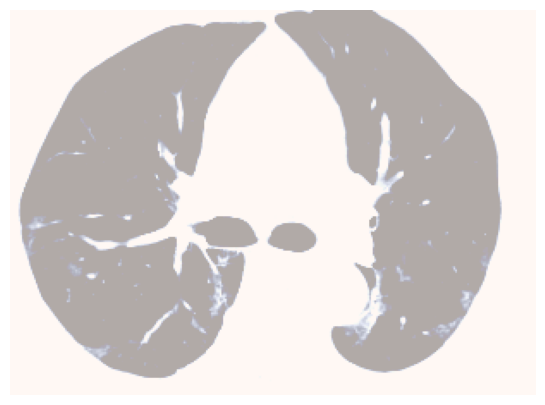

Model Prediction: Highly Cancer Positive (Probabilities: Positive=1.0000, Negative=0.0000)


In [ ]:
import shap
import torch
import numpy as np
from efficientnet_pytorch import EfficientNet
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model
model = EfficientNet.from_pretrained('efficientnet-b3')
model._fc = torch.nn.Linear(model._fc.in_features, 2)  # Adjust final layer for binary classification (positive/negative)
model.load_state_dict(torch.load('best_model_state.bin', map_location=torch.device('cpu')))
model.eval()

# Move model to device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Image transformation for resizing and normalizing
transform = transforms.Compose([
    transforms.Resize(224),  # Ensure all images are resized to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image from a given path
def load_image(img_path):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension and move to device (GPU/CPU)
    return img_tensor

# Predict cancer class (positive/negative) and get class probabilities
def predict_with_probabilities(model, img_tensor):
    output = model(img_tensor)
    probabilities = torch.softmax(output, dim=1)
    return probabilities.cpu().detach().numpy()  # Return class probabilities for both classes

# SHAP Explainer for PyTorch using GradientExplainer
def explain_model(model, img_tensor):
    # Use some background images for SHAP explanations
    background_data = torch.cat([load_image('/content/data/train/POSITIVE/CANCER_POSITIVE_102.png') for _ in range(5)])
    explainer = shap.GradientExplainer(model, background_data)

    # SHAP values calculated for both classes (positive and negative)
    shap_values = explainer.shap_values(img_tensor)
    return shap_values

# Overlay SHAP values on the image
def overlay_shap_on_image(image_tensor, shap_values, alpha=0.7):
    # Convert the image tensor from (C, H, W) to (H, W, C) for display
    img_array = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()

    # SHAP values for positive contributions (cancer-positive)
    shap_values_pos = shap_values[0][0].sum(axis=0)  # Sum SHAP values across all channels to get a 2D heatmap

    # Normalize SHAP values to [0, 1] for display
    if shap_values_pos.max() > 0:
        shap_values_norm = (shap_values_pos - shap_values_pos.min()) / (shap_values_pos.max() - shap_values_pos.min() + 1e-5)
    else:
        shap_values_norm = shap_values_pos  # If all zero, just pass the values as is

    # Resize SHAP values to match the image size
    shap_values_resized = np.resize(shap_values_norm, img_array.shape[:2])

    # Plot the original image
    plt.figure(figsize=(10, 5))
    plt.imshow(img_array)  # Original image

    # Overlay SHAP values as a heatmap
    plt.imshow(shap_values_resized, cmap='Reds', alpha=alpha)  # Highlight positive contributions with red

    plt.axis('off')
    plt.show()

# Function to display the prediction and SHAP explanation with custom labels
def display_prediction_and_shap(img_path):
    img_tensor = load_image(img_path)

    # Get the model's prediction probabilities
    probabilities = predict_with_probabilities(model, img_tensor)

    # Determine the predicted class (0 for negative, 1 for positive)
    prediction = np.argmax(probabilities)

    # SHAP explanation for the image
    shap_values = explain_model(model, img_tensor)

    # Display SHAP explanation overlayed on the original image
    overlay_shap_on_image(img_tensor, shap_values)

    # Define custom label for the prediction based on the probabilities
    positive_prob = probabilities[0][1]  # Probability for cancer-positive class
    negative_prob = probabilities[0][0]  # Probability for cancer-negative class

    if positive_prob > 0.9:  # Highly confident about cancer-positive
        label = "Highly Cancer Positive"
    elif negative_prob > 0.9:  # Highly confident about cancer-negative
        label = "Highly Cancer Negative"
    else:
        label = "Uncertain Classification"  # If confidence is low for both classes

    # Print prediction information
    print(f"Model Prediction: {label} (Probabilities: Positive={positive_prob:.4f}, Negative={negative_prob:.4f})")

# Example paths for the dataset (you can update them with paths from your dataset)
positive_img_paths = [
    '/content/data/train/POSITIVE/CANCER_POSITIVE_102.png'
]

# Test the model and SHAP explanation for the positive image
for img_path in positive_img_paths:
    print(f"Testing Positive Image: {img_path}")
    display_prediction_and_shap(img_path)


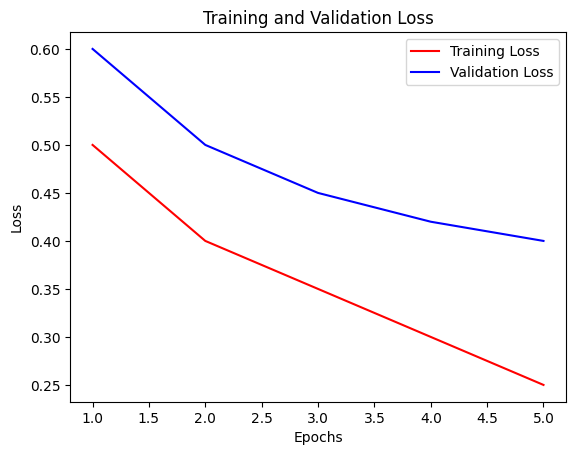

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the losses saved during training
# Example: loss_stats is a dictionary with 'train' and 'val' keys, and their respective loss values for each epoch
loss_stats = {
    'train': [0.5, 0.4, 0.35, 0.3, 0.25],  # replace these with your actual training loss values
    'val': [0.6, 0.5, 0.45, 0.42, 0.4]     # replace these with your actual validation loss values
}

# Number of epochs
epochs = range(1, len(loss_stats['train']) + 1)

# Plot training and validation loss
plt.plot(epochs, loss_stats['train'], 'r', label='Training Loss')
plt.plot(epochs, loss_stats['val'], 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])
Batch size (inputs): torch.Size([16, 3, 224, 224])
Batch size (probs): torch.Size([16, 2])

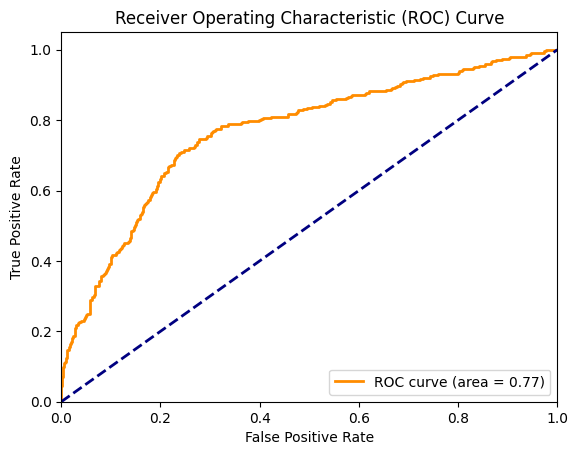

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Define transformations for test data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load your test dataset (replace with your actual path)
test_dataset = ImageFolder('/content/drive/MyDrive/Dataset/test', transform=transform)

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Set model to evaluation mode
base_model.eval()

# Placeholder for predicted probabilities and true labels
y_pred_prob = []
y_test_list = []

# Move model to the correct device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

# Get predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Get the raw model output (logits)
        outputs = base_model(inputs)

        # Apply sigmoid to get probabilities for binary classification
        probs = torch.softmax(outputs, dim=1)  # Use softmax to get probabilities for both classes

        # DEBUGGING: Print the shape of the inputs and probabilities for each batch
        print(f"Batch size (inputs): {inputs.shape}")
        print(f"Batch size (probs): {probs.shape}")

        # Append the probabilities for the positive class (class 1)
        y_pred_prob.extend(probs[:, 1].cpu().numpy())  # Use probs[:, 1] to get positive class probabilities

        # Append the true labels
        y_test_list.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
y_pred_prob = np.array(y_pred_prob).ravel()  # Ensure it's a 1D array of probabilities for the positive class
y_test = np.array(y_test_list)

# DEBUGGING: Check lengths after predictions
print(f"Final y_test length: {len(y_test)}")
print(f"Final y_pred_prob length: {len(y_pred_prob)}")

# Ensure the lengths match
assert len(y_test) == len(y_pred_prob), f"Mismatch in lengths: {len(y_test)} vs {len(y_pred_prob)}"

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
